In [118]:
import childespy
import numpy as np

In [ ]:
df = childespy.get_utterances(language='eng')

R[write to console]: Using current database version: '2021.1'.

R[write to console]: Getting data from 7659 children in 387 corpora...



In [392]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6942258 entries, 1440 to 6942258
Data columns (total 27 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   id                 6942258 non-null  int32  
 1   gloss              6942258 non-null  object 
 2   stem               6942258 non-null  object 
 3   actual_phonology   6942258 non-null  object 
 4   model_phonology    6942258 non-null  object 
 5   type               6942258 non-null  object 
 6   language           6942258 non-null  object 
 7   num_morphemes      6942258 non-null  int32  
 8   num_tokens         6942258 non-null  int32  
 9   utterance_order    6942258 non-null  int32  
 10  corpus_name        6942258 non-null  object 
 11  part_of_speech     6942258 non-null  object 
 12  speaker_code       6942258 non-null  object 
 13  speaker_name       6942258 non-null  object 
 14  speaker_role       6942258 non-null  object 
 15  target_child_name  6942258 no

In [2]:
import pandas as pd
store = pd.HDFStore('childes_db_store.h5')
df = store['childes_eng_df']

In [5]:
df.head()

,id,gloss,stem,actual_phonology,model_phonology,type,language,num_morphemes,num_tokens,utterance_order,...,target_child_sex,media_start,media_end,media_unit,collection_name,collection_id,corpus_id,speaker_id,target_child_id,transcript_id
1440,1440,well you wanna,well you want,,,question,eng,4,3,1,...,female,NaN,NaN,None,Frogs,1,1,3,1,1
1456,1456,now what I have next is another book,now what I have next be another book,,,declarative,eng,9,8,2,...,female,NaN,NaN,None,Frogs,1,1,3,1,1
1464,1464,this is a smaller book though,this be a small book though,,,declarative,eng,8,6,3,...,female,NaN,NaN,None,Frogs,1,1,3,1,1
1472,1472,this one's called a boy a dog and a frog,this one call a boy a dog and a frog,,,declarative,eng,12,10,4,...,female,NaN,NaN,None,Frogs,1,1,3,1,1
1498,1498,and like the last book there are no words but ...,and like the last book there be no word but re...,,,trail off,eng,18,13,5,...,female,NaN,NaN,None,Frogs,1,1,3,1,1


In [7]:
df[['part_of_speech']].head()

,part_of_speech
1,co
2,pro:sub v qn pro:indef prep pro:obj inf v
3,v v pro:int post pro:sub v prep det:art n
4,pro:sub v qn pro:indef pro:dem det:art adj adj
5,pro:dem pro:indef v det:art n det:art n coord ...


## Extract child statement, followed by parent question

The hope being that some of these are adult reformulations

In [17]:
df['type'].value_counts()

declarative                   5010735
question                      1535722
imperative_emphatic            198973
trail off                      106272
interruption                    33801
self interruption               22085
missing CA terminator           21161
quotation next line              8100
trail off question               1774
interruption question            1631
self interruption question       1096
quotation precedes                863
broken for coding                  31
question exclamation               11
no break TCU continuation           3
Name: type, dtype: int64

In [4]:
df.index = df.index.astype(int)
df = df.sort_values(['transcript_id', 'utterance_order'])

In [349]:
# NOTE: for now, not restricting utterance type and seeing what happens

child_decl = (
    (df['speaker_id'] == df['target_child_id'])
    # & (df['type'] == 'declarative') 
)

after_child_decl = np.concatenate(([False], child_decl.values[:-1]))
prev_target_child_id = np.concatenate(([None], df['target_child_id'].values[:-1]))
parent_followup_q = (
    after_child_decl 
    # & (df['type'] == 'question')
    & (prev_target_child_id == df['target_child_id']) 
    & (df['speaker_id'] != df['target_child_id'])
)
child_decl_before_q = np.concatenate((parent_followup_q.values[1:], [False]))

In [350]:
sdf = df[child_decl_before_q | parent_followup_q]
sdf_child = df[child_decl_before_q]
sdf_parent = df[parent_followup_q]

In [351]:
ssdf_c = sdf_child[['gloss', 'stem', 'type', 'target_child_age', 
                    'utterance_order', 'transcript_id']].copy()
ssdf_p = sdf_parent[['gloss', 'stem', 'type', 'target_child_age', 
                     'utterance_order', 'transcript_id']].copy()
assert(len(ssdf_c) == len(ssdf_p))

# make sure target age for child is matching between parent/child (and non-null)
matching_child_age = (ssdf_c['target_child_age'].values == ssdf_p['target_child_age'].values)
ssdf_c = ssdf_c[matching_child_age]
ssdf_p = ssdf_p[matching_child_age]

# ssdf_p = ssdf_p.query('target_child_age >= 24 and target_child_age < 36')
# ssdf_c = ssdf_c.query('target_child_age >= 24 and target_child_age < 36')
assert(len(ssdf_c) == len(ssdf_p))

ssdf_c['parent_gloss'] = ssdf_p['gloss'].values
ssdf_c['parent_stem'] = ssdf_p['stem'].values
ssdf_c['parent_type'] = ssdf_p['type'].values

In [352]:
gloss_leven_dists = [leven(x, y) for x, y in zip(ssdf_c['gloss'], ssdf_c['parent_gloss'])]
ssdf_c['gloss_dist'] = gloss_leven_dists

ssdf_c['gloss_len'] = [len(x.split()) for x in ssdf_c['gloss']]
ssdf_c['parent_gloss_len'] = [len(x.split()) for x in ssdf_c['parent_gloss']]

ssdf_c['gloss_dist_norm'] = (ssdf_c['gloss_dist'] / 
                             (ssdf_c[['gloss_len', 'parent_gloss_len']].max(axis=1)))

stem_leven_dists = [leven(x, y) for x, y in zip(ssdf_c['stem'], ssdf_c['parent_stem'])]
ssdf_c['stem_dist'] = stem_leven_dists

ssdf_c['stem_len'] = [len(x.split()) for x in ssdf_c['stem']]
ssdf_c['parent_stem_len'] = [len(x.split()) for x in ssdf_c['parent_stem']]

ssdf_c['stem_dist_norm'] = (ssdf_c['stem_dist'] / 
                            (ssdf_c[['stem_len', 'parent_stem_len']].max(axis=1)))


In [363]:
# reorder columns
ssdf_c = ssdf_c[['gloss', 'parent_gloss', 'stem', 'parent_stem',
                 'gloss_dist_norm', 'stem_dist_norm', 'gloss_dist','stem_dist',
                 'type', 'parent_type', 'target_child_age', 'utterance_order', 'transcript_id', 
                 'gloss_len', 'parent_gloss_len', 'stem_len', 'parent_stem_len', ]]

In [361]:
ssdf_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1617996 entries, 1579 to 6919674
Data columns (total 17 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   gloss             1617996 non-null  object 
 1   parent_gloss      1617996 non-null  object 
 2   stem              1617996 non-null  object 
 3   parent_stem       1617996 non-null  object 
 4   gloss_dist_norm   1608039 non-null  float64
 5   stem_dist_norm    1502246 non-null  float64
 6   gloss_dist        1617996 non-null  int64  
 7   stem_dist         1617996 non-null  int64  
 8   type              1617996 non-null  object 
 9   target_child_age  1617996 non-null  float64
 10  utterance_order   1617996 non-null  int32  
 11  transcript_id     1617996 non-null  int32  
 12  gloss_len         1617996 non-null  int64  
 13  parent_gloss_len  1617996 non-null  int64  
 14  stem_len          1617996 non-null  int64  
 15  parent_stem_len   1617996 non-null  int64  
 1

In [355]:
ssdf_c.to_csv('child_parent_reformulations_unrestricted_utterance_type.csv', index=False)

In [356]:
# using gloss vs. stem usually doesn't change the edit distance
# but if it does, the stem usually pulls the two closer 
# (since it's the base forms of the words)
# so probably should use stem distance over gloss

print((ssdf_c['gloss_dist_norm'] == ssdf_c['stem_dist_norm']).mean())
print((ssdf_c['gloss_dist_norm'] < ssdf_c['stem_dist_norm']).mean())
print((ssdf_c['gloss_dist_norm'] > ssdf_c['stem_dist_norm']).mean())

0.8517394356969981
0.01114712273701542
0.06557432774864709


In [383]:
ssdf_c[
    (ssdf_c['stem_dist_norm'] >= 0)
    & (ssdf_c['stem_dist_norm'] <= 0.7) 
    # & (ssdf_c['target_child_age'] >= 48) 
    & (ssdf_c['target_child_age'] >= 30)
].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260239 entries, 93 to 6919539
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   gloss             260239 non-null  object 
 1   parent_gloss      260239 non-null  object 
 2   stem              260239 non-null  object 
 3   parent_stem       260239 non-null  object 
 4   gloss_dist_norm   260239 non-null  float64
 5   stem_dist_norm    260239 non-null  float64
 6   gloss_dist        260239 non-null  int64  
 7   stem_dist         260239 non-null  int64  
 8   type              260239 non-null  object 
 9   parent_type       260239 non-null  object 
 10  target_child_age  260239 non-null  float64
 11  utterance_order   260239 non-null  int32  
 12  transcript_id     260239 non-null  int32  
 13  gloss_len         260239 non-null  int64  
 14  parent_gloss_len  260239 non-null  int64  
 15  stem_len          260239 non-null  int64  
 16  parent_stem_len   

In [393]:
ssdf_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1617996 entries, 1579 to 6919674
Data columns (total 17 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   gloss             1617996 non-null  object 
 1   parent_gloss      1617996 non-null  object 
 2   stem              1617996 non-null  object 
 3   parent_stem       1617996 non-null  object 
 4   gloss_dist_norm   1608039 non-null  float64
 5   stem_dist_norm    1502246 non-null  float64
 6   gloss_dist        1617996 non-null  int64  
 7   stem_dist         1617996 non-null  int64  
 8   type              1617996 non-null  object 
 9   parent_type       1617996 non-null  object 
 10  target_child_age  1617996 non-null  float64
 11  utterance_order   1617996 non-null  int32  
 12  transcript_id     1617996 non-null  int32  
 13  gloss_len         1617996 non-null  int64  
 14  parent_gloss_len  1617996 non-null  int64  
 15  stem_len          1617996 non-null  int64  
 1

In [400]:
ssdf_c[ssdf_c['stem'] != ''].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296150 entries, 1605 to 6919674
Data columns (total 17 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   gloss             1296150 non-null  object 
 1   parent_gloss      1296150 non-null  object 
 2   stem              1296150 non-null  object 
 3   parent_stem       1296150 non-null  object 
 4   gloss_dist_norm   1296150 non-null  float64
 5   stem_dist_norm    1296150 non-null  float64
 6   gloss_dist        1296150 non-null  int64  
 7   stem_dist         1296150 non-null  int64  
 8   type              1296150 non-null  object 
 9   parent_type       1296150 non-null  object 
 10  target_child_age  1296150 non-null  float64
 11  utterance_order   1296150 non-null  int32  
 12  transcript_id     1296150 non-null  int32  
 13  gloss_len         1296150 non-null  int64  
 14  parent_gloss_len  1296150 non-null  int64  
 15  stem_len          1296150 non-null  int64  
 1

In [409]:
ss

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1253996 entries, 2 to 1617995
Data columns (total 16 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   gloss             1253964 non-null  object 
 1   parent_gloss      1253995 non-null  object 
 2   stem              1253996 non-null  object 
 3   parent_stem       1253996 non-null  object 
 4   gloss_dist_norm   1253996 non-null  float64
 5   stem_dist_norm    1253996 non-null  float64
 6   gloss_dist        1253996 non-null  int64  
 7   stem_dist         1253996 non-null  int64  
 8   type              1253996 non-null  object 
 9   target_child_age  1253996 non-null  float64
 10  utterance_order   1253996 non-null  int64  
 11  transcript_id     1253996 non-null  int64  
 12  gloss_len         1253996 non-null  int64  
 13  parent_gloss_len  1253996 non-null  int64  
 14  stem_len          1253996 non-null  int64  
 15  parent_stem_len   1253996 non-null  int64  
dtype

In [413]:
ssdf_c_notna[(ssdf_c_notna['stem_dist_norm'] <= 0.7) & 
       (ssdf_c_notna['target_child_age'] < 600000)].head(10)

,gloss,parent_gloss,child_utterance_stem,adult_reformulation_stem,gloss_dist_norm,stem_dist_norm,gloss_dist,stem_dist,type,target_child_age,utterance_order,transcript_id,gloss_len,parent_gloss_len,stem_len,parent_stem_len
77,uhoh,uhoh,uhoh,uhoh,0.000000,0.000000,0,0,declarative,79.001622,3,10,1,1,1,1
84,I'm all ready,all right,I all ready,all right,0.666667,0.666667,2,2,declarative,79.001622,39,10,3,2,3,2
121,yeah,yeah,yeah,yeah,0.000000,0.000000,0,0,declarative,78.001602,17,13,1,1,1,1
141,hard,that was hard,hard,that be hard,0.666667,0.666667,2,2,declarative,78.001602,4,15,1,3,1,3
147,where's the first xxx page,here's the first page,where the first page,here the first page,0.400000,0.250000,2,1,question,78.001602,28,15,5,4,4,4
153,his favorite word guess what his favorite word is,what's his favorite word,guess what his favorite word be,what his favorite word,0.666667,0.333333,6,2,question,78.001602,48,15,9,4,6,4
154,mine,mine,mine,mine,0.000000,0.000000,0,0,declarative,78.001602,50,15,1,1,1,1
159,a xxx,that's a log,a,that a log,0.666667,0.666667,2,2,declarative,78.001602,74,15,2,3,1,3
196,yeah,yeah,yeah,yeah,0.000000,0.000000,0,0,declarative,78.001602,13,18,1,1,1,1
201,and the frog,and that's the end,and the frog,and that the end,0.500000,0.500000,2,2,declarative,78.001602,43,18,3,4,3,4


In [417]:
ssdf_c_notna = ssdf_c_notna.rename(columns={
    'stem': 'child_utterance_stem', 'parent_stem': 'adult_reformulation_stem'})
df_reformulations = ssdf_c_notna[(ssdf_c_notna['stem_dist_norm'] <= 0.7)]
df_reformulations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260239 entries, 58 to 1253992
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   gloss                     260228 non-null  object 
 1   parent_gloss              260239 non-null  object 
 2   child_utterance_stem      260239 non-null  object 
 3   adult_reformulation_stem  260239 non-null  object 
 4   gloss_dist_norm           260239 non-null  float64
 5   stem_dist_norm            260239 non-null  float64
 6   gloss_dist                260239 non-null  int64  
 7   stem_dist                 260239 non-null  int64  
 8   type                      260239 non-null  object 
 9   target_child_age          260239 non-null  float64
 10  utterance_order           260239 non-null  int64  
 11  transcript_id             260239 non-null  int64  
 12  gloss_len                 260239 non-null  int64  
 13  parent_gloss_len          260239 non-null 

In [418]:
df_reformulations = df_reformulations.sort_values(['transcript_id', 'utterance_order'])
df_reformulations.to_csv('Apr112022_child_adult_reformulations_nonull.csv', index=False)

In [27]:
from sklearn.model_selection import train_test_split
import pandas as pd

df_reformulations = pd.read_csv('Apr112022_child_adult_reformulations_nonull.csv')
nonull_gloss = (df_reformulations['gloss'].notna() & df_reformulations['parent_gloss'].notna())
df_reformulations = df_reformulations[nonull_gloss]
df_reformulations.to_csv('Apr112022_child_adult_reformulations_nonull.csv', index=False)
# train/val/test: 75/10/15 split
df_train, df_test = train_test_split(df_reformulations, 
                                     test_size=0.15, random_state=3141)
df_train, df_val = train_test_split(df_train, 
                                    test_size=0.1/0.85, random_state=3141)

In [12]:
df_reformulations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260228 entries, 0 to 260227
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   gloss                     260228 non-null  object 
 1   parent_gloss              260228 non-null  object 
 2   child_utterance_stem      260228 non-null  object 
 3   adult_reformulation_stem  260228 non-null  object 
 4   gloss_dist_norm           260228 non-null  float64
 5   stem_dist_norm            260228 non-null  float64
 6   gloss_dist                260228 non-null  int64  
 7   stem_dist                 260228 non-null  int64  
 8   type                      260228 non-null  object 
 9   target_child_age          260228 non-null  float64
 10  utterance_order           260228 non-null  int64  
 11  transcript_id             260228 non-null  int64  
 12  gloss_len                 260228 non-null  int64  
 13  parent_gloss_len          260228 non-null  i

In [ ]:
below_age_cutoff = df_reformulations['target_child_age'] < 30
print(df_reformulations[below_age_cutoff].info())
print(df_reformulations[~below_age_cutoff].info())
df_reformulations[below_age_cutoff].head()

In [28]:
print(df_train.info())
print(df_val.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195170 entries, 205927 to 213276
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   gloss                     195170 non-null  object 
 1   parent_gloss              195170 non-null  object 
 2   child_utterance_stem      195170 non-null  object 
 3   adult_reformulation_stem  195170 non-null  object 
 4   gloss_dist_norm           195170 non-null  float64
 5   stem_dist_norm            195170 non-null  float64
 6   gloss_dist                195170 non-null  int64  
 7   stem_dist                 195170 non-null  int64  
 8   type                      195170 non-null  object 
 9   target_child_age          195170 non-null  float64
 10  utterance_order           195170 non-null  int64  
 11  transcript_id             195170 non-null  int64  
 12  gloss_len                 195170 non-null  int64  
 13  parent_gloss_len          195170 non-nu

In [29]:
df_train.to_csv('Apr112022_child_adult_reformulations_nonull_train.csv', index=False)
df_val.to_csv('Apr112022_child_adult_reformulations_nonull_val.csv', index=False)
df_test.to_csv('Apr112022_child_adult_reformulations_nonull_test.csv', index=False)

In [22]:
print(len(df_train.query('target_child_age < 36')))
print(len(df_train.query('target_child_age >= 36')))

128667
66512


In [25]:
print(df_val.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024 entries, 0 to 26023
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   gloss                     26023 non-null  object 
 1   parent_gloss              26024 non-null  object 
 2   child_utterance_stem      26024 non-null  object 
 3   adult_reformulation_stem  26024 non-null  object 
 4   gloss_dist_norm           26024 non-null  float64
 5   stem_dist_norm            26024 non-null  float64
 6   gloss_dist                26024 non-null  int64  
 7   stem_dist                 26024 non-null  int64  
 8   type                      26024 non-null  object 
 9   target_child_age          26024 non-null  float64
 10  utterance_order           26024 non-null  int64  
 11  transcript_id             26024 non-null  int64  
 12  gloss_len                 26024 non-null  int64  
 13  parent_gloss_len          26024 non-null  int64  
 14  stem_l

In [ ]:
ssdf_c_young = ssdf_c[ssdf_c['target_child_age'] < 30]
print(len(ssdf_c_young))
ssdf_c_young['stem_dist_norm'].hist()

In [386]:
ssdf_c_young['stem_dist_norm'].mean()

0.8459268237957849

391879


<AxesSubplot:>

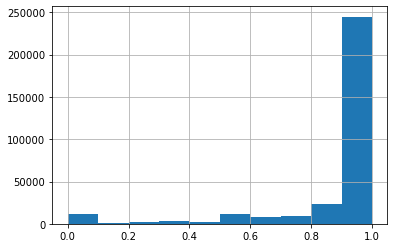

In [390]:
ssdf_c_old = ssdf_c[ssdf_c['target_child_age'] >= 48]
print(len(ssdf_c_old))
ssdf_c_old['stem_dist_norm'].hist()

In [391]:
ssdf_c_old['stem_dist_norm'].mean()

0.8996004047679451

In [191]:
rand_choices = np.random.choice(len(ssdf_c), 10)
ssdf_c.iloc[rand_choices]

,gloss,parent_gloss,stem,parent_stem,gloss_dist_norm,stem_dist_norm,gloss_dist,stem_dist,type,target_child_age,utterance_order,transcript_id,gloss_len,parent_gloss_len,stem_len,parent_stem_len
4604122,xxx,xxx primroses xxx didn't you,,primrose do you,0.800000,1.000000,4,3,declarative,60.099797,9,25604,1,5,0,3
1373794,you use this pen this pen,is that a pen,you use this pen this pen,be that a pen,0.833333,0.833333,5,5,declarative,32.394916,1658,7004,6,4,6,4
6148130,five,five,,,0.000000,NaN,0,0,declarative,50.395285,457,36790,1,1,0,0
3131840,blue,where's her red jacket,blue,where her red jacket,1.000000,1.000000,4,4,declarative,31.394895,317,24462,1,4,1,4
6091188,xxx finshed,how do you say hello,,,1.000000,NaN,5,0,declarative,48.132405,689,36302,2,5,0,0
2968744,horsie,a horse,horse,a horse,1.000000,0.500000,2,1,declarative,31.657734,1094,24328,1,2,1,2
4075838,I don't wanna,but you xxx on the furniture,I do want,but you on the furniture,1.000000,1.000000,6,5,declarative,36.066449,573,25142,3,6,3,5
1630374,Pinkuh,what,Pinkuh,what,1.000000,1.000000,1,1,declarative,46.986591,14,7419,1,1,1,1
4743707,do that,what do you wanna do Miranda today,do that,what do you want do Miranda today,0.857143,0.857143,6,6,declarative,30.592004,80,25971,2,7,2,7
3346237,oh dear,is the driver sitting in the cab,oh dear,be the drive sit in the cab,1.000000,1.000000,7,7,declarative,26.033389,891,24660,2,7,2,7


In [125]:
def leven(x, y):
    x = x.split()
    y = y.split()
    n = len(x)
    m = len(y)

    A = [[i + j for j in range(m + 1)] for i in range(n + 1)]

    for i in range(n):
        for j in range(m):
            A[i + 1][j + 1] = min(A[i][j + 1] + 1,              # insert
                                  A[i + 1][j] + 1,              # delete
                                  A[i][j] + int(x[i] != y[j]))  # replace

    return A[n][m]

In [ ]:
child_st = (df['type'] == 'question') & (df['speaker_id'] != df['target_child_id'])
after_parent_question = np.concatenate(([False], parent_question.values[:-1]))
prev_target_child_id = np.concatenate(([None], df['target_child_id'].values[:-1]))
child_answer = after_parent_question & (prev_target_child_id == df['target_child_id']) & (df['speaker_id'] == df['target_child_id'])
before_child_answer = np.concatenate((child_answer.values[1:], [False]))

In [4]:
df = df.sort_values(['transcript_id', 'utterance_order'])

In [5]:
parent_question = (df['type'] == 'question') & (df['speaker_id'] != df['target_child_id'])
after_parent_question = np.concatenate(([False], parent_question.values[:-1]))
prev_target_child_id = np.concatenate(([None], df['target_child_id'].values[:-1]))
child_answer = after_parent_question & (prev_target_child_id == df['target_child_id']) & (df['speaker_id'] == df['target_child_id'])
before_child_answer = np.concatenate((child_answer.values[1:], [False]))

In [6]:
qa_df = df[before_child_answer | child_answer]
qa_df.head(n=20)

,id,gloss,stem,actual_phonology,model_phonology,type,language,num_morphemes,num_tokens,utterance_order,...,target_child_sex,media_start,media_end,media_unit,collection_name,collection_id,corpus_id,speaker_id,target_child_id,transcript_id
2,371043,what was the book about,what be the book about,,,question,eng,7,5,2,...,male,NaN,NaN,None,Eng-NA,2,37,1741,1740,3768
3,371047,ow,ow,,,declarative,eng,1,1,3,...,male,NaN,NaN,None,Eng-NA,2,37,1740,1740,3768
4,371050,ow,ow,,,question,eng,1,1,4,...,male,NaN,NaN,None,Eng-NA,2,37,1741,1740,3768
5,371054,yeah,yeah,,,declarative,eng,1,1,5,...,male,NaN,NaN,None,Eng-NA,2,37,1740,1740,3768
6,371057,want a bite of my cracker,want a bite of my cracker,,,question,eng,6,6,6,...,male,NaN,NaN,None,Eng-NA,2,37,1741,1740,3768
7,371061,ow,ow,,,declarative,eng,1,1,7,...,male,NaN,NaN,None,Eng-NA,2,37,1740,1740,3768
9,371066,Richard,Richard,,,question,eng,1,1,9,...,male,NaN,NaN,None,Eng-NA,2,37,1741,1740,3768
10,371069,no,no,,,declarative,eng,1,1,10,...,male,NaN,NaN,None,Eng-NA,2,37,1740,1740,3768
11,371071,what's he doing,what he do,,,question,eng,5,3,11,...,male,NaN,NaN,None,Eng-NA,2,37,1741,1740,3768
12,371075,no yeah,no yeah,,,trail off,eng,2,2,12,...,male,NaN,NaN,None,Eng-NA,2,37,1740,1740,3768


In [7]:
df.index = df.index.astype(int)

In [8]:
qa_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15452 entries, 2 to 39905
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15452 non-null  int32  
 1   gloss              15452 non-null  object 
 2   stem               15452 non-null  object 
 3   actual_phonology   15452 non-null  object 
 4   model_phonology    15452 non-null  object 
 5   type               15452 non-null  object 
 6   language           15452 non-null  object 
 7   num_morphemes      15452 non-null  int32  
 8   num_tokens         15452 non-null  int32  
 9   utterance_order    15452 non-null  int32  
 10  corpus_name        15452 non-null  object 
 11  part_of_speech     15452 non-null  object 
 12  speaker_code       15452 non-null  object 
 13  speaker_name       15452 non-null  object 
 14  speaker_role       15452 non-null  object 
 15  target_child_name  15452 non-null  object 
 16  target_child_age   15452 no